## This Code is to Train Model

In [10]:
import keras as kr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import os
import pickle
import gzip
import gc
import cv2
import mediapipe as mp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from i3d_inception import Inception_Inflated3d, conv3d_bn
from keras.ops import mean
from custom_stgcn import Model as STGCNModel
from keras.layers import Dropout, Reshape, Lambda, Activation
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import Sequence, to_categorical
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [11]:
import winsound
def playSound():
    winsound.PlaySound("C:/Users/Lenovo/Music/Chicory, A Colorful Tale/Dinners The Big City.wav", winsound.SND_ASYNC)

def stopSound():
    winsound.PlaySound(None, winsound.SND_PURGE)

## Output Directories

In [12]:
rgb_dataset_dir = "./data-preprocess/rgb/"
farneback_dataset_dir = "./data-preprocess/optical_flow_farneback/"
tvl1_dataset_dir = "./data-preprocess/optical_flow_tvl1/"
skeleton_dataset_dir = "./data-preprocess/pose/"

model_output_dir = "./output-models"

rgb_model_path = "./output-models/rgb_model.keras"
farneback_model_path = "./output-models/farneback_model.keras"
tvl1_model_path = "./output-models/tvl1_model.keras"
skeleton_model_path = "./output-models/skeleton_model.keras"

rgb_model_history_path = "./output-models/rgb_model_history.csv"
farneback_model_history_path = "./output-models/farneback_model_history.csv"
tvl1_model_history_path = "./output-models/tvl1_model_history.csv"
skeleton_model_history_path = "./output-models/skeleton_model_history.csv"

glossary_path = "./glossary.json"
labelEncoder_path = "./label_encoder.pkl"
data_splitting_path = "./data_splitting.json"

hand_landmarker_path = "./models/hand_landmarker.task"
pose_landmarker_path = "./models/pose_landmarker_heavy.task"

## Data Preparation

## Loads Pose Landmarker

In [13]:
# for joint recognition, we use pose_landmarker from mediapipe
pose_base_options = python.BaseOptions(model_asset_path=pose_landmarker_path)
pose_options = vision.PoseLandmarkerOptions(base_options=pose_base_options, num_poses=1)
pose_predictor = vision.PoseLandmarker.create_from_options(pose_options)

# for hand joint recognition, we use hand_landmarker from mediapipe
hand_base_options = python.BaseOptions(model_asset_path=hand_landmarker_path)
hand_options = vision.HandLandmarkerOptions(base_options=hand_base_options, num_hands=2)
hand_predictor = vision.HandLandmarker.create_from_options(hand_options)

### Loads Glossary

In [14]:
# loads glossary
glossary = json.load(open(glossary_path, "r"))
listId = [gloss["file_id"] for gloss in glossary]
labels = [gloss["word"] for gloss in glossary]

# turn into numpy arrays
listId = np.array(listId)
labels = np.array(labels)

print("Number of classes:", np.unique(labels).shape[0])
print("Number of samples:", listId.shape[0])

Number of classes: 50
Number of samples: 290


In [15]:
# tally the number of samples per class
class_counts = pd.Series(labels).value_counts()

<Axes: title={'center': 'Number of samples per class'}>

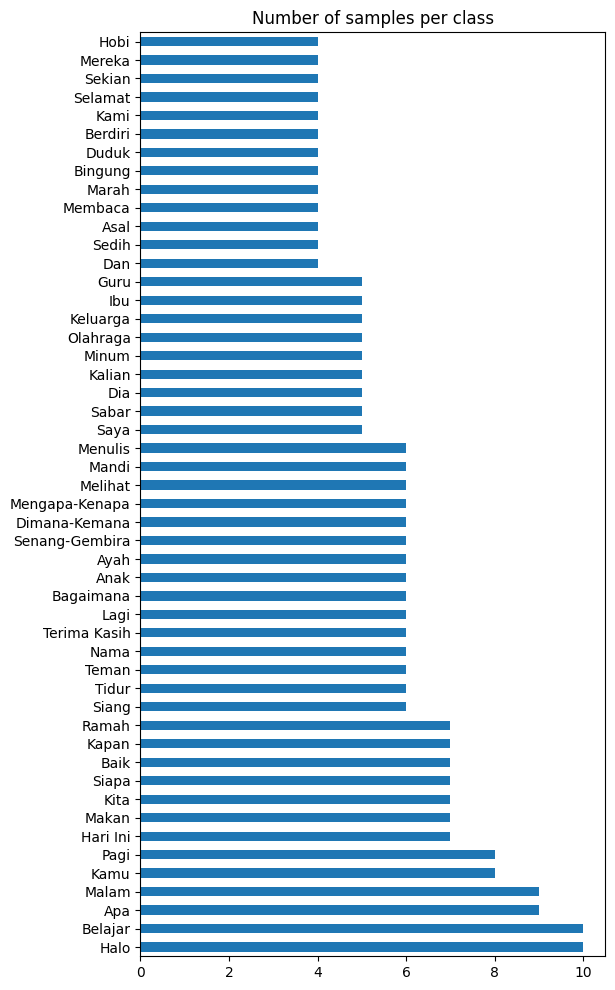

In [16]:
class_counts.plot(kind='barh', figsize=(6, 12), title='Number of samples per class')

### Label Encoding

In [17]:
# uses label encoder then one-hot encodes the labels
# check if label encoder exists, if not create it
if os.path.exists(labelEncoder_path):
    print("label encoder already exists, loading it...")
    with open(labelEncoder_path, "rb") as f:
        le = pickle.load(f)
else:
    print("label encoder does not exist, creating it...")
    le = LabelEncoder()
    le.fit(labels)

    # save label encoder
    with open(labelEncoder_path, "wb") as f:
        pickle.dump(le, f)

num_classes = len(le.classes_)

# encode labels
labels = le.transform(labels)

label encoder already exists, loading it...


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Splitting
this research splits dataset into a ratio of 4:1:1 train, test, and validation respectively

In [18]:
X = listId
y = labels

if os.path.exists(data_splitting_path):
    print("Data segmentation already exists, loading it...")
    data_segmentation = json.load(open(data_splitting_path, "r"))
else:
    # splitting dataset 4:1:1 train:validation:test
    X_train, X_combined, y_train, y_combined = train_test_split(X, y, test_size=2/6)
    X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=1/2)

    data_segmentation = {
        "train": {
            "listId": X_train.tolist(),
            "labels": y_train.tolist()
        },
        "validation": {
            "listId": X_val.tolist(),
            "labels": y_val.tolist()
        },
        "test": {
            "listId": X_test.tolist(),
            "labels": y_test.tolist()
        }
    }

    # save data segmentation
    with open(data_splitting_path, "w") as f:
        json.dump(data_segmentation, f)

video_and_glosses = {}

for iii in range(len(listId)):
    video_and_glosses[X[iii]] = y[iii]

X_train = np.array(data_segmentation["train"]["listId"])
y_train = np.array(data_segmentation["train"]["labels"])
X_val = np.array(data_segmentation["validation"]["listId"])
y_val = np.array(data_segmentation["validation"]["labels"])
X_test = np.array(data_segmentation["test"]["listId"])
y_test = np.array(data_segmentation["test"]["labels"])

print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Test samples:", X_test.shape[0])

Data segmentation already exists, loading it...
Train samples: 193
Validation samples: 48
Test samples: 49


## Model Settings

The preparation before using model. This includes Data Generator, randomizer function, etc

In [19]:
batch_size = 6
num_epochs = 200
early_stopping_patience = 2

video_dimensions = (64, 224, 224, 3)

In [20]:
def mirror_video(frames: list):
    """
    Mirrors the video frames horizontally
    """
    return [cv2.flip(frame, 1) for frame in frames]

def randomCropping(frames: list, crop_size=(224, 224)):
    """
    Randomly crops the video frames to the specified size
    """
    # Check if the frames are longer than the crop size
    h, w = frames[0].shape[:2]
    ch, cw = crop_size

    if h < ch or w < cw:
        raise ValueError("Crop size must be smaller than frame dimensions")

    top = np.random.randint(0, h - ch + 1)
    left = np.random.randint(0, w - cw + 1)

    cropped_frames = [frame[top:top + ch, left:left + cw] for frame in frames]
    
    return cropped_frames

def i3d_normalization(x: np.ndarray) -> np.ndarray:
    """
    Normalize input frames for I3D model.
    The normalization is done by scaling pixel values to the range [-1, 1].
    """
    x = x.astype(np.float16)
    x = (x / 127.5) - 1.0
    return x

def forceFrames(frames: list, num_frames=64, padding_technique="firstOrLast", chance=0.5):
    """
    Forces the video frames to have a fixed number of frames.
    assuming the frames have less length than num_frames frames.
    """
    # turn into list of np.array
    frames = [np.array(frame) for frame in frames]
    random_choice = np.random.rand()
    if padding_technique == "firstOrLast":
        # pad with first or last frame
        if random_choice > chance:
            # pad with first element at the start
            padding_frame = frames[0]
            data = [padding_frame] * (num_frames - len(frames)) + frames
        else:
            # pad with last element at the end
            padding_frame = frames[-1]
            data = frames + [padding_frame] * (num_frames - len(frames))

    elif padding_technique == "zero":
        # pad with zero frames first or last
        single_frame_shape = frames[0].shape
        padding_frame = np.zeros(single_frame_shape, dtype=frames[0].dtype)
        
        if random_choice > chance:
            # pad with zero frame at the start
            data = [padding_frame] * (num_frames - len(frames)) + frames
        else:
            # pad with zero frame at the end
            data = frames + [padding_frame] * (num_frames - len(frames))

    return data

def temporalCropping(frames: list, num_frames=64):
    """
    Do a temporal cropping of the video frames to force the number of frames to be num_frames.
    get a random start index and crop the frames to the specified number of frames.
    assuming the frames have more length than num_frames frames.
    """
    start_index = np.random.randint(0, len(frames) - num_frames + 1)
    cropped_frames = frames[start_index:start_index + num_frames]
    return cropped_frames


def combinePose(pose_dict):
    """
    Combine pose body, left hand, and right hand into a single array.
    """
    combined = []
    # each frame
    frame_count = len(pose_dict['pose'])
    for frame in range(frame_count):
        temp = []
        for key in ['pose', 'left_hand', 'right_hand']:
            for idx in range(len(pose_dict[key][frame])):
                temp.append(pose_dict[key][frame][idx])
        combined.append(temp)
    return np.array(combined, dtype=np.float16)

# only includes left/right shoulder and elbow
body_pose_lookup = [14, 12, 11, 13]
body_pose_joints = [[14, 12], [12, 11], [11, 13]]

# uses all hand poses
hand_pose_joints = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [0, 5],
    [5, 6],
    [6, 7],
    [7, 8],
    [5, 9],
    [9, 10],
    [10, 11],
    [11, 12],
    [13, 14],
    [14, 15],
    [15, 16],
    [13, 17],
    [17, 18],
    [18, 19],
    [19, 20],
    [0, 17]
]

def predict_pose_and_hand_keypoints(results_pose: list, results_hand: list):
    """
    Predict the pose and hand keypoints from the MediaPipe result.
    Returns a dictionary with pose keypoints and hand keypoints.
    """
    pose_keypoints = []
    left_hand_keypoints = []
    right_hand_keypoints = []

    for result in results_hand:
        left_hand = np.zeros((21, 3), dtype=np.float16)
        right_hand = np.zeros((21, 3), dtype=np.float16)

        for idx, handedness in enumerate(result.handedness):
            list_hand = []

            for landmark in result.hand_landmarks[idx]:
                list_hand.append((landmark.x, landmark.y, landmark.z))
            
            if handedness[0].index == 0:  # left hand
                left_hand = np.array(list_hand, dtype=np.float16)
            if handedness[0].index == 1: # right hand
                right_hand = np.array(list_hand, dtype=np.float16)
        
        left_hand_keypoints.append(left_hand)
        right_hand_keypoints.append(right_hand)

    # Extract pose keypoints
    for result in results_pose:
        pose = []  # 4 joints, 3 coordinates (x, y, z)
        # check if pose_landmarks is not empty
        if not result.pose_landmarks:
            # if no pose landmarks detected, append zeroes
            pose = np.zeros((4, 3), dtype=np.float16)
        else:
            for idx, landmark in enumerate(result.pose_landmarks[0]):
                if idx not in body_pose_lookup:
                    continue
                pose.append((landmark.x, landmark.y, landmark.z))
    
        pose_keypoints.append(pose)

    return {
        "pose": np.array(pose_keypoints, dtype=np.float16),
        "left_hand": np.array(left_hand_keypoints, dtype=np.float16),
        "right_hand": np.array(right_hand_keypoints, dtype=np.float16)
    }

def predictMpFrames(frames: list):
    """
    Predicts the pose and hand landmarks for the given frames using MediaPipe.
    """
    hand_landmarks = []
    pose_landmarks = []
    for frame in frames:
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        hand_landmarks.append(hand_predictor.detect(mp_image))
        pose_landmarks.append(pose_predictor.detect(mp_image))

    keypoints = predict_pose_and_hand_keypoints(pose_landmarks, hand_landmarks)
    pose_combined = combinePose(keypoints)

    return pose_combined

In [21]:
# create data generator for training, loads lazily
# data generator for I3D model
class DataGenerator(Sequence):
    def __init__(
            self, 
            listIDs, 
            out_dir,
            batch_size=32, 
            dim=(64, 224, 224, 3), 
            n_classses=50,
            shuffle=True,
            dictionary=video_and_glosses,
            normalize=True,
            padding_technique = "firstOrLast" # firstOrlast or zero
        ):
        self.dim = dim
        self.batch_size = batch_size
        self.listIDs = listIDs
        self.n_classes = n_classses
        self.shuffle = shuffle
        self.out_dir = out_dir
        self.dictionary = dictionary
        self.normalize = normalize
        self.padding_technique = padding_technique
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.listIDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        gc.collect()

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim), dtype=np.float16)
        y = np.empty((self.batch_size), dtype=np.float16)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Load data and get label
            with gzip.open(os.path.join(self.out_dir, ID + ".pkl.gz"), 'rb') as f:
                data = pickle.load(f) # assuming it's a list of np.ndarray frames
                if len(data) < self.dim[0]:
                    # if the video has less than 64 frames, pad it
                    data = forceFrames(data, num_frames=self.dim[0], padding_technique=self.padding_technique)
                elif len(data) > self.dim[0]:
                    # if the video has more than 64 frames, crop it
                    data = temporalCropping(data, num_frames=self.dim[0])

                # do a random cropping
                data = randomCropping(data, crop_size=(224, 224))

                # 50% chance to mirror the video frames
                if np.random.rand() > 0.5:
                    data = mirror_video(data)

                # Convert to numpy array and normalize
                data = np.array(data, dtype=np.float16)

                if self.normalize:
                    X[i,] = i3d_normalization(data)
                else:
                    X[i,] = data
                
            y[i,] = self.dictionary[ID]

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.listIDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.listIDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, to_categorical(y, num_classes=self.n_classes)

In [22]:
# create data generator for training, loads lazily
# data generator for I3D model
class DataGenerator_Skeleton(Sequence):
    def __init__(
            self, 
            listIDs, 
            out_dir,
            batch_size=32, 
            dim=(64, 46, 3),
            n_classses=50,
            shuffle=True,
            dictionary=video_and_glosses,
            padding_technique = "firstOrLast" # firstOrlast or zero
        ):
        self.dim = dim
        self.batch_size = batch_size
        self.listIDs = listIDs
        self.n_classes = n_classses
        self.shuffle = shuffle
        self.out_dir = out_dir
        self.dictionary = dictionary
        self.padding_technique = padding_technique
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.listIDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, self.dim[2], self.dim[0], self.dim[1], 1), dtype=np.float16)
        y = np.empty((self.batch_size), dtype=np.float16)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Load data and get label
            # load video data
            with gzip.open(os.path.join(self.out_dir, ID + ".pkl.gz"), 'rb') as f:
                pose = pickle.load(f)  # assuming it's a list of np.ndarray frames
                pose = combinePose(pose)

            if len(pose) > self.dim[0]:
                # if the video has more than 64 frames, crop it
                pose = temporalCropping(pose, num_frames=self.dim[0])
            elif len(pose) < self.dim[0]:
                # if the video has less than 64 frames, pad it
                pose = forceFrames(pose, num_frames=self.dim[0], padding_technique=self.padding_technique)

            # add tensor dimension
            pose = np.expand_dims(pose, axis=-1)
            pose = np.transpose(pose, (2, 0, 1, 3))  

            # Convert to numpy array
            pose = np.array(pose, dtype=np.float16)

            y[i,] = self.dictionary[ID]
            X[i,] = pose

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.listIDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.listIDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, to_categorical(y, num_classes=self.n_classes)

In [23]:
# create data generator for training, loads lazily
# data generator for I3D model
class DataGenerator_Skeleton_Old(Sequence):
    def __init__(
            self, 
            listIDs, 
            out_dir,
            batch_size=32, 
            dim=(64, 46, 3),
            n_classses=50,
            shuffle=True,
            dictionary=video_and_glosses,
            padding_technique = "firstOrLast" # firstOrlast or zero
        ):
        self.dim = dim
        self.batch_size = batch_size
        self.listIDs = listIDs
        self.n_classes = n_classses
        self.shuffle = shuffle
        self.out_dir = out_dir
        self.dictionary = dictionary
        self.padding_technique = padding_technique
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.listIDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, self.dim[2], self.dim[0], self.dim[1], 1), dtype=np.float16)
        y = np.empty((self.batch_size), dtype=np.float16)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Load data and get label
            # load video data
            with gzip.open(os.path.join(self.out_dir, ID + ".pkl.gz"), 'rb') as f:
                video_data = pickle.load(f)  # assuming it's a list of np.ndarray frames

            if len(video_data) > self.dim[0]:
                # if the video has more than 64 frames, crop it
                video_data = temporalCropping(video_data, num_frames=self.dim[0])

            # add spatial cropping
            video_data = randomCropping(video_data)

            # 50% chance to mirror the video frames
            if np.random.rand() > 0.5:
                video_data = mirror_video(video_data)
            
            video_data = np.array(video_data, dtype=np.uint8)

            # predict the pose using mediapipe
            pose = predictMpFrames(video_data)

            if len(pose) < self.dim[0]:
                # if the video has less than 64 frames, pad it
                pose = forceFrames(pose, num_frames=self.dim[0], padding_technique=self.padding_technique)

            # add tensor dimension
            pose = np.expand_dims(pose, axis=-1)
            pose = np.transpose(pose, (2, 0, 1, 3))  

            # Convert to numpy array
            pose = np.array(pose, dtype=np.float16)

            y[i,] = self.dictionary[ID]
            X[i,] = pose

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.listIDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.listIDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, to_categorical(y, num_classes=self.n_classes)

In [24]:
def create_callbacks(
        output_path: str,
        patience: int = 2, 
        verbose = 0,
        save_history_path: str | None = None
    ):
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=patience,
            verbose=verbose,
            mode='max',
            restore_best_weights=True
        ),
        ModelCheckpoint(
            output_path,
            monitor='val_accuracy',
            verbose=verbose,
            save_best_only=True,
            mode='max',
            save_weights_only=False
        )
    ]

    if save_history_path is not None:
        callbacks.append(
            CSVLogger(
                save_history_path,
                append=True,
            )
        )
        
    return callbacks

## Models

There are 2 models used for this research: I3D and ST-GCN, I3D model is used to predict rgb of the signers and the optical flow, and ST-GCN is used to predict pose from mediapipe

### I3D Model

I3D model accepts 64 frames rgb video with 224 x 224 dimension, for optical flow, the channel uses 2 instead of 3 rgb channel. We put 

In [25]:
def baseline_model_i3d(
        num_classes: int, 
        learning_rate: float = 1e-3, 
        weight_decay: float = 1e-7
        ) -> Model:
    base_model = Inception_Inflated3d(
        include_top=False,
        weights="rgb_imagenet_and_kinetics",
        input_shape=(64, 224, 224, 3),
    )

    # turn on training for the base model
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output

    x = Dropout(0.5, name='Dropout_5a')(x)

    x = conv3d_bn(x, num_classes, 1, 1, 1, padding='same', 
                    use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

    num_frames = int(x.shape[1])  # Number of frames in the input video
    x = Reshape((num_frames, num_classes))(x)

    x = Lambda(lambda x: mean(x, axis=1, keepdims=False),
                output_shape=lambda s: (s[0], s[2]))(x)

    model_i3d = Model(inputs=base_model.input, outputs=x, name='Inception_Inflated3d')

    model_i3d.compile(
        optimizer=kr.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
        loss=kr.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model_i3d

In [26]:
def baseline_model_i3d_flow(
        num_classes: int,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-7
) -> Model:
    base_model = Inception_Inflated3d(
        include_top=False,
        weights="flow_kinetics_only",
        input_shape=(64, 224, 224, 2),
    )

    x = base_model.output

    x = Dropout(0.5, name='Dropout_5a')(x)

    x = conv3d_bn(x, num_classes, 1, 1, 1, padding='same', 
                    use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

    num_frames = int(x.shape[1])  # Number of frames in the input video
    x = Reshape((num_frames, num_classes))(x)

    x = Lambda(lambda x: mean(x, axis=1, keepdims=False),
                output_shape=lambda s: (s[0], s[2]))(x)

    model_flow = Model(inputs=base_model.input, outputs=x, name='Inception_Inflated3d')

    model_flow.compile(
        optimizer=kr.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
        loss=kr.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model_flow

### ST-GCN Model

In [27]:
def baseline_model_stgcn(
    num_classes: int,
    learning_rate: float = 0.01,
    weight_decay: float = 1e-4
):
    model_pose = STGCNModel(num_classes=num_classes)

    dummy_input = np.random.normal(size=(1, 3, 64, 46, 1))  # Note: 3 channels (x,y,z coordinates)
    _ = model_pose(dummy_input, training=True)  # This builds the model

    model_pose.compile(
        optimizer=kr.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
        loss=kr.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model_pose


In [28]:
# get random sample
sample_files = np.random.choice(X_train, size=20, replace=False)

samples = []
for sample_id in sample_files:
    # load the video frames
    with gzip.open(os.path.join(rgb_dataset_dir, sample_id + ".pkl.gz"), 'rb') as f:
        data = pickle.load(f)  # assuming it's a list of np.ndarray frames
    if (len(data) < 64):
        continue
    # data = temporalCropping(data, num_frames=64)  # ensure it has 64 frames
    samples.append(data)

In [29]:
idx = 8
frame_cropped = temporalCropping(samples[idx], num_frames=64)
frame_crop = randomCropping(frame_cropped, crop_size=(224, 224))
frame_mirrror = mirror_video(frame_crop)

In [30]:
len(frame_crop[0][0])

224

In [31]:
# save all samples as .mp4 files

def saveMp4(frames, filename):
    sample_out_dir = "./sample"
    for i, sample in enumerate([frame_cropped]):
        sample = np.array(sample, dtype=np.uint8)
        out_path = os.path.join(sample_out_dir, f"sampletemporalcrop_{i}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        
        out = cv2.VideoWriter(out_path, fourcc, 30.0, (len(sample[0]), len(sample[0][0])))
        
        for frame in sample:
            # frame bgr
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        out.release()

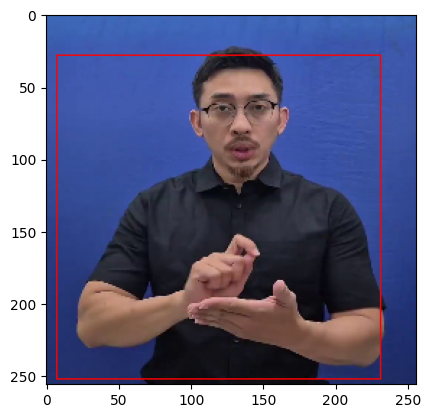

In [32]:
# find a random video from the dataset
random_video_id = X_train[48]
frame_idx = 20
#  load the video frames
with gzip.open(os.path.join(rgb_dataset_dir, random_video_id + ".pkl.gz"), 'rb') as f:
    frames = pickle.load(f)

frame = frames[frame_idx]

# Check if the frames are longer than the crop size
h, w = frame.shape[:2]
ch, cw = (224, 224)

if h < ch or w < cw:
    raise ValueError("Crop size must be smaller than frame dimensions")

top = np.random.randint(0, h - ch + 1)
left = np.random.randint(0, w - cw + 1)

cropped_frames = frame[top:top + ch, left:left + cw]

# mark the randomized crop area in red rectangle
frame = cv2.rectangle(frame, (left, top), (left + cw, top + ch), (255, 0, 0), 1)

plt.imshow(frame)

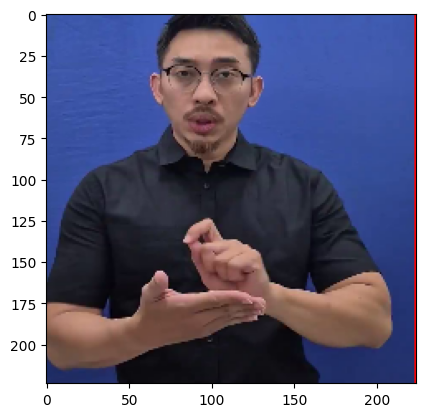

In [33]:
# spatial flipping
cropped_frames = cv2.flip(cropped_frames, 1)

plt.imshow(cropped_frames)

## Training Stage

### RGB Model

In [34]:
model_rgb = baseline_model_i3d(num_classes=num_classes)
if os.path.exists(rgb_model_path):
    print("RGB model already exists, loading it...")
    model_rgb.load_weights(rgb_model_path)

RGB model already exists, loading it...


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 234 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
rgb_padding_technique = "firstOrLast"
training_generator = DataGenerator(
    X_train,
    dictionary=video_and_glosses,
    out_dir=rgb_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 3),
    n_classses=num_classes,
    padding_technique=rgb_padding_technique
)

validation_generator = DataGenerator(
    X_val,
    dictionary=video_and_glosses,
    out_dir=rgb_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 3),
    n_classses=num_classes,
    padding_technique=rgb_padding_technique
)

try:
    model_rgb.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=200,
        verbose=1,
        callbacks=create_callbacks(
            rgb_model_path, 
            patience=early_stopping_patience,
            verbose=1,
            save_history_path=rgb_model_history_path
        ),
    )
except Exception as e:
    print("An error occurred during training:", e)
    playSound()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.0342 - loss: 4.0040 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to ./output-models/rgb_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1608s 50s/step - accuracy: 0.0336 - loss: 4.0049 - val_accuracy: 0.0000e+00 - val_loss: 6.6827
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.0921 - loss: 3.6089 
Epoch 2: val_accuracy improved from 0.00000 to 0.06250, saving model to ./output-models/rgb_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1547s 48s/step - accuracy: 0.0935 - loss: 3.6056 - val_accuracy: 0.0625 - val_loss: 8.6651
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.2028 - loss: 3.2052 
Epoch 3: val_accuracy improved from 0.06250 to 0.14583, saving model to ./output-models/rgb_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1632s 51s/step - accuracy: 0.2047 - loss: 3.1991 - val_accuracy: 0.1458 - val_loss: 3.9530
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.4126 - los

Text(0, 0.5, 'Accuracy')

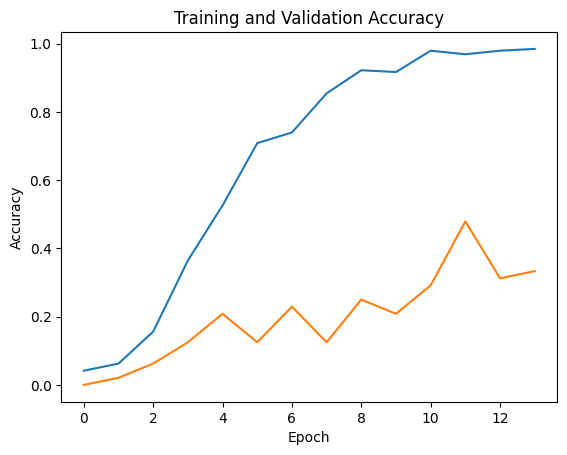

In [19]:
# load the csv file
csv_history = pd.read_csv(rgb_model_history_path)

plt.plot(csv_history['epoch'], csv_history['accuracy'], label='Training Accuracy')
plt.plot(csv_history['epoch'], csv_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Optical Flow Model

### Farneback

In [20]:
model_farneback = baseline_model_i3d_flow(num_classes=num_classes)
if os.path.exists(farneback_model_path):
    print("farneback model already exists, loading it...")
    model_farneback.load_weights(farneback_model_path)

c:\Users\Lenovo\Documents\codes\pythons\machine learning\skripsi\new_skripsi\Data\i3d_inception.py:98: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


farneback model already exists, loading it...


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 234 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
farneback_padding_technique = "zero"  # zero or firstOrLast
training_generator = DataGenerator(
    X_train,
    dictionary=video_and_glosses,
    out_dir=farneback_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique=farneback_padding_technique
)

validation_generator = DataGenerator(
    X_val,
    dictionary=video_and_glosses,
    out_dir=farneback_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique=farneback_padding_technique
)

try:
    model_farneback.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=200,
        verbose=1,
        callbacks=create_callbacks(
            farneback_model_path,
            patience=early_stopping_patience,
            verbose=1,
            save_history_path=farneback_model_history_path
        ),
    )
except Exception as e:
    print("Error during training:", e)
    playSound()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.1135 - loss: 3.5611 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to ./output-models/farneback_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1574s 48s/step - accuracy: 0.1134 - loss: 3.5636 - val_accuracy: 0.0000e+00 - val_loss: 4.1437
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.2790 - loss: 3.0949 
Epoch 2: val_accuracy improved from 0.00000 to 0.06250, saving model to ./output-models/farneback_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1435s 45s/step - accuracy: 0.2780 - loss: 3.0951 - val_accuracy: 0.0625 - val_loss: 4.5357
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.3991 - loss: 2.5252 
Epoch 3: val_accuracy improved from 0.06250 to 0.08333, saving model to ./output-models/farneback_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1447s 45s/step - accuracy: 0.3992 - loss: 2.5250 - val_accuracy: 0.0833 - val_loss: 4.4921
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accu

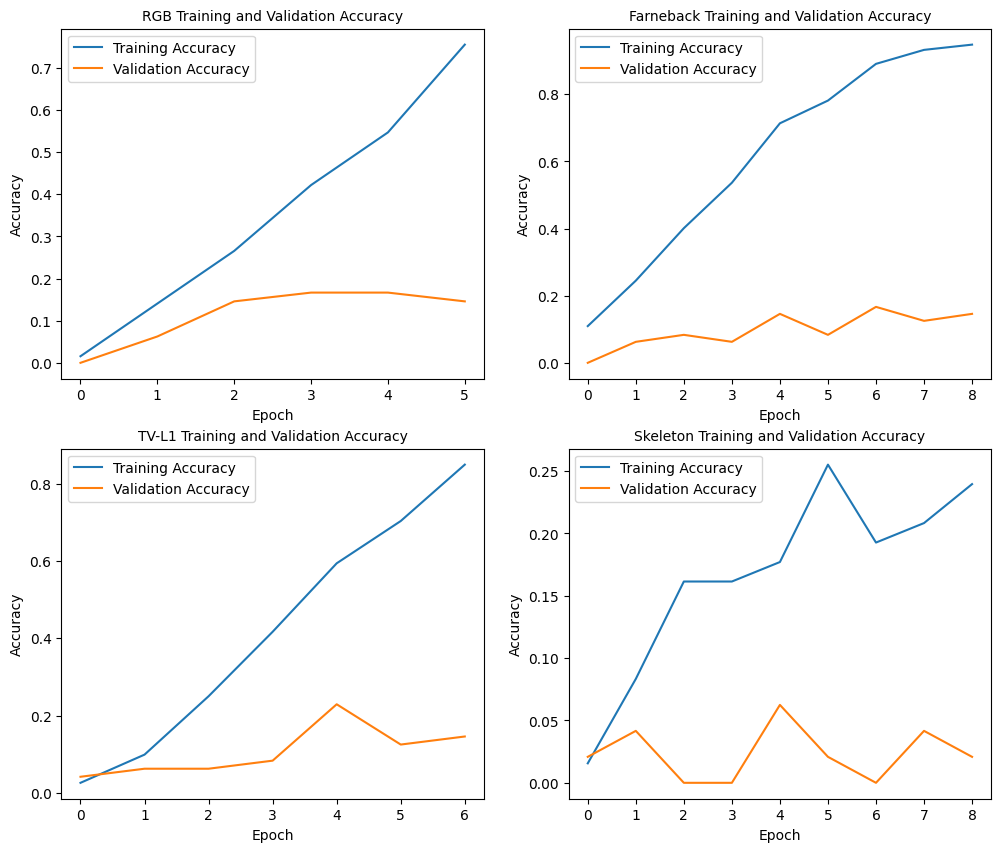

In [ ]:
# load the csv file
dicts = {
    "RGB": rgb_model_history_path,
    "Farneback": farneback_model_history_path,
    "TV-L1": tvl1_model_history_path,
    "Skeleton": skeleton_model_history_path
}


plt.figure(figsize=(12, 10))
iii = 1
for key, value in dicts.items():
    csv_history = pd.read_csv(value)

    plt.subplot(2, 2, iii)
    plt.plot(csv_history['epoch'], csv_history['accuracy'], label='Training Accuracy')
    plt.plot(csv_history['epoch'], csv_history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{key} Training and Validation Accuracy', fontsize=10)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    iii += 1

In [ ]:
# calculate top-1 top-5 and top-10 accuracies
testing_generator = DataGenerator(
    X_test,
    dictionary=video_and_glosses,
    out_dir=farneback_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique="zero"
)

prediction = model_farneback.predict(testing_generator)

top_1_accuracy = calculate_top_k_accuracy(prediction, y_test, k=1)
top_5_accuracy = calculate_top_k_accuracy(prediction, y_test, k=5)
top_10_accuracy = calculate_top_k_accuracy(prediction, y_test, k=10)

print(f"Top-1 Accuracy: {top_1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")
print(f"Top-10 Accuracy: {top_10_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step
Top-1 Accuracy: 0.3673
Top-5 Accuracy: 0.7347
Top-10 Accuracy: 0.8571


### TV-L1

In [21]:
model_tvl1 = baseline_model_i3d_flow(num_classes=num_classes)
if os.path.exists(tvl1_model_path):
    print("tvl1 model already exists, loading it...")
    model_tvl1.load_weights(tvl1_model_path)

tvl1 model already exists, loading it...


In [ ]:
tvl1_padding_technique = "zero"  # zero or firstOrLast
training_generator = DataGenerator(
    X_train,
    dictionary=video_and_glosses,
    out_dir=tvl1_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique=tvl1_padding_technique
)

validation_generator = DataGenerator(
    X_val,
    dictionary=video_and_glosses,
    out_dir=tvl1_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique=tvl1_padding_technique
)

try:
    model_tvl1.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=200,
        verbose=1,
        callbacks=create_callbacks(
            tvl1_model_path,
            patience=early_stopping_patience,
            verbose=1,
            save_history_path=tvl1_model_history_path
        ),
    )
except Exception as e:
    print("Error during training:", e)
    playSound()

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.0125 - loss: 3.9706 
Epoch 1: val_accuracy improved from -inf to 0.04167, saving model to ./output-models/tvl1_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1544s 48s/step - accuracy: 0.0129 - loss: 3.9708 - val_accuracy: 0.0417 - val_loss: 4.1974
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.1095 - loss: 3.6794 
Epoch 2: val_accuracy improved from 0.04167 to 0.06250, saving model to ./output-models/tvl1_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1475s 46s/step - accuracy: 0.1091 - loss: 3.6789 - val_accuracy: 0.0625 - val_loss: 4.2036
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.2706 - loss: 3.1788 
Epoch 3: val_accuracy did not improve from 0.06250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1530s 48s/step - accuracy: 0.2700 - loss: 3.1782 - val_accuracy: 0.0625 - val_loss: 4.1054
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.4369 - loss: 2.3865 
Epoch 4: val_accuracy improved from 0.06250 

Text(0, 0.5, 'Accuracy')

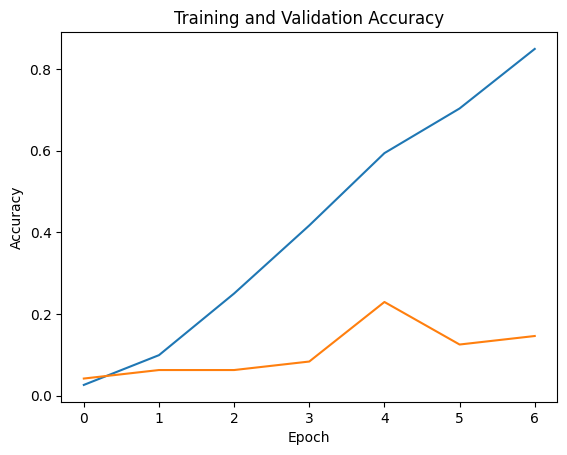

In [ ]:
# load the csv file
csv_history = pd.read_csv(tvl1_model_history_path)

plt.plot(csv_history['epoch'], csv_history['accuracy'], label='Training Accuracy')
plt.plot(csv_history['epoch'], csv_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# calculate top-1 top-5 and top-10 accuracies
testing_generator = DataGenerator(
    X_test,
    dictionary=video_and_glosses,
    out_dir=tvl1_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique="zero"
)

prediction = model_tvl1.predict(testing_generator)

top_1_accuracy = calculate_top_k_accuracy(prediction, y_test, k=1)
top_5_accuracy = calculate_top_k_accuracy(prediction, y_test, k=5)
top_10_accuracy = calculate_top_k_accuracy(prediction, y_test, k=10)

print(f"Top-1 Accuracy: {top_1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")
print(f"Top-10 Accuracy: {top_10_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step
Top-1 Accuracy: 0.3265
Top-5 Accuracy: 0.7143
Top-10 Accuracy: 0.7959


### Skeleton Model

In [22]:
model_skeleton = baseline_model_stgcn(num_classes=num_classes, learning_rate=1e-3, weight_decay=1e-7)
if os.path.exists(skeleton_model_path):
    print("skeleton model already exists, loading it...")
    model_skeleton.load_weights(skeleton_model_path)

skeleton model already exists, loading it...


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 186 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
training_generator = DataGenerator_Skeleton(
    X_train,
    dictionary=video_and_glosses,
    out_dir=skeleton_dataset_dir,
    batch_size=batch_size,
    dim=(64, 46, 3),
    n_classses=num_classes,
)

validation_generator = DataGenerator_Skeleton(
    X_val,
    dictionary=video_and_glosses,
    out_dir=skeleton_dataset_dir,
    batch_size=batch_size,
    dim=(64, 46, 3),
    n_classses=num_classes,
)

try:
    model_skeleton.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=200,
        verbose=1,
        callbacks=create_callbacks(
            skeleton_model_path,
            patience=early_stopping_patience + 2,
            verbose=1,
            save_history_path=skeleton_model_history_path,
        ),
    )
except Exception as e:
    print("Error during training:", e)
    playSound()

Epoch 1/200


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0284 - loss: 7.6896
Epoch 1: val_accuracy improved from -inf to 0.04167, saving model to ./output-models/skeleton_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.0280 - loss: 7.6510 - val_accuracy: 0.0417 - val_loss: 33.4855
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0585 - loss: 4.2680
Epoch 2: val_accuracy did not improve from 0.04167
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.0588 - loss: 4.2730 - val_accuracy: 0.0000e+00 - val_loss: 7.0760
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0780 - loss: 4.2693
Epoch 3: val_accuracy did not improve from 0.04167
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.0777 - loss: 4.2701 - val_accuracy: 0.0000e+00 - val_loss: 6.5030
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0962 - loss: 3.9594
Epoch 4: val_accuracy improved from 0.04167 to 0.06250, saving model to ./output-models/skeleton_model.keras
32/32

Text(0, 0.5, 'Accuracy')

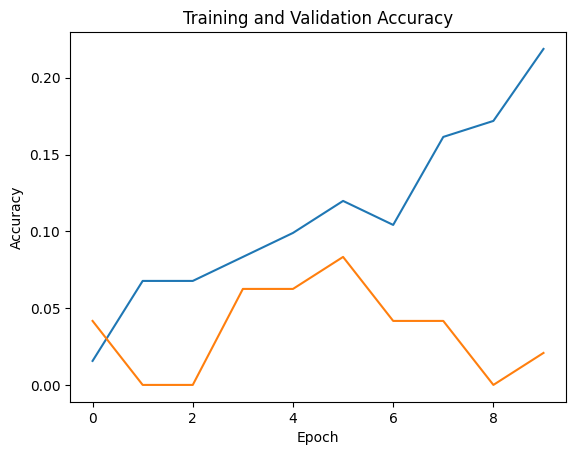

In [45]:
# load the csv file
csv_history = pd.read_csv(skeleton_model_history_path)

plt.plot(csv_history['epoch'], csv_history['accuracy'], label='Training Accuracy')
plt.plot(csv_history['epoch'], csv_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0.5, 1.0, 'Skeleton Model Accuracy')

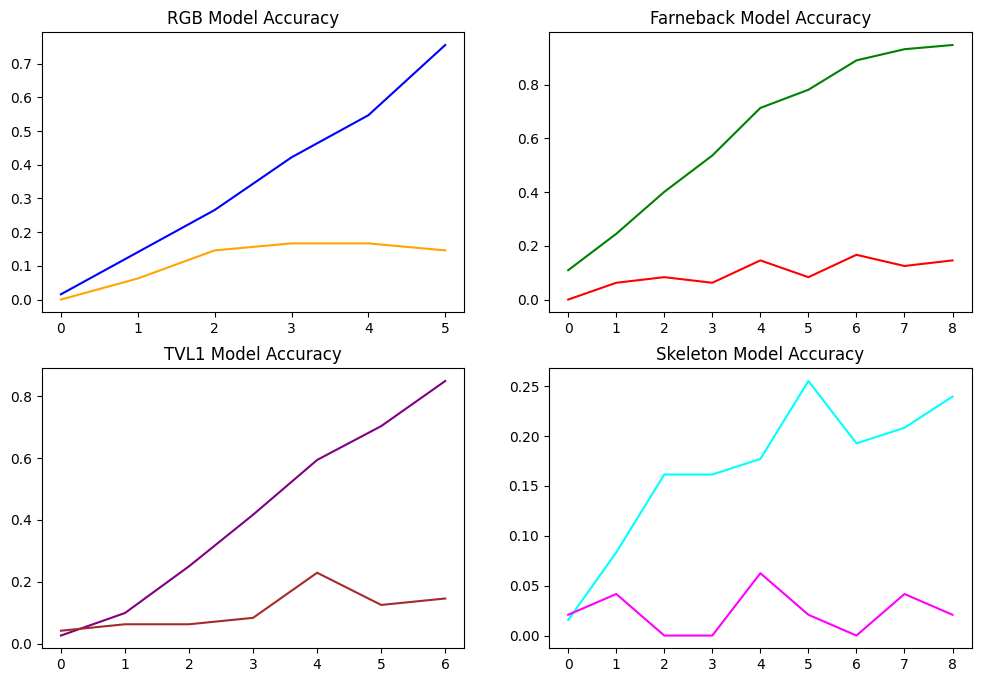

In [35]:
rgb_eval_csv = pd.read_csv(rgb_model_history_path)
farneback_eval_csv = pd.read_csv(farneback_model_history_path)
tvl1_eval_csv = pd.read_csv(tvl1_model_history_path)
skeleton_eval_csv = pd.read_csv(skeleton_model_history_path)

# Plotting the evaluation metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(rgb_eval_csv['epoch'], rgb_eval_csv['accuracy'], label='RGB Training Accuracy', color='blue')
plt.plot(rgb_eval_csv['epoch'], rgb_eval_csv['val_accuracy'], label='RGB Validation Accuracy', color='orange')
plt.title('RGB Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(farneback_eval_csv['epoch'], farneback_eval_csv['accuracy'], label='Farneback Training Accuracy', color='green')
plt.plot(farneback_eval_csv['epoch'], farneback_eval_csv['val_accuracy'], label='Farneback Validation Accuracy', color='red')
plt.title('Farneback Model Accuracy')

plt.subplot(2, 2, 3)
plt.plot(tvl1_eval_csv['epoch'], tvl1_eval_csv['accuracy'], label='TVL1 Training Accuracy', color='purple')
plt.plot(tvl1_eval_csv['epoch'], tvl1_eval_csv['val_accuracy'], label='TVL1 Validation Accuracy', color='brown')
plt.title('TVL1 Model Accuracy')

plt.subplot(2, 2, 4)
plt.plot(skeleton_eval_csv['epoch'], skeleton_eval_csv['accuracy'], label='Skeleton Training Accuracy', color='cyan')
plt.plot(skeleton_eval_csv['epoch'], skeleton_eval_csv['val_accuracy'], label='Skeleton Validation Accuracy', color='magenta')
plt.title('Skeleton Model Accuracy')

## Testing Stage

In [ ]:
# using combined model, calculate top-N accuracies
# no shuffle this time
people_generator = DataGenerator(
    X_test,
    dictionary=video_and_glosses,
    out_dir=rgb_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 3),
    n_classses=num_classes,
    padding_technique="firstOrLast",
    shuffle=False,
    normalize=True
)

skeleton_generator = DataGenerator_Skeleton(
    X_test,
    dictionary=video_and_glosses,
    out_dir=skeleton_dataset_dir,
    batch_size=batch_size,
    dim=(64, 46, 3),
    n_classses=num_classes,
    padding_technique="firstOrLast",
    shuffle=False
)

farneback_generator = DataGenerator(
    X_test,
    dictionary=video_and_glosses,
    out_dir=farneback_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique="zero",
    shuffle=False
)

tvl1_generator = DataGenerator(
    X_test,
    dictionary=video_and_glosses,
    out_dir=tvl1_dataset_dir,
    batch_size=batch_size,
    dim=(64, 224, 224, 2),
    n_classses=num_classes,
    normalize=False,
    padding_technique="zero",
    shuffle=False
)

In [27]:
# predict all
people_prediction = model_rgb.predict(people_generator)
skeleton_prediction = model_skeleton.predict(skeleton_generator)
farneback_prediction = model_farneback.predict(farneback_generator)
tvl1_prediction = model_tvl1.predict(tvl1_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step


In [25]:
# predict top-k
def calculate_combined_top_k_accuracy(
    preds: list,
    k=1
):
    """
    Calculate combined top-k accuracy from multiple predictions.
    assuming each prediction have the same shape (num_samples, num_classes)
    preds: list of predictions from different models (model -> video -> predictions)
    k: top-k accuracy to calculate
    """
    combined_preds = np.mean(preds, axis=0)  # Average the predictions
    top_k_preds = np.argsort(combined_preds, axis=1)[:, -k:]  # Get top-k predictions
    correct_preds = np.isin(y_test, top_k_preds)  # Check if true labels are in top-k predictions
    return np.mean(correct_preds)

combinations = {
    "rgb": [people_prediction],
    "farneback": [farneback_prediction],
    "tvl1": [tvl1_prediction],
    "skeleton": [skeleton_prediction],

    "rgb + farneback": [people_prediction, farneback_prediction],
    "rgb + tvl1": [people_prediction, tvl1_prediction],
    "rgb + skeleton": [people_prediction, skeleton_prediction],
    "farneback + skeleton": [farneback_prediction, skeleton_prediction],
    "tvl1 + skeleton": [tvl1_prediction, skeleton_prediction],

    "rgb + farneback + skeleton": [people_prediction, farneback_prediction, skeleton_prediction],
    "rgb + tvl1 + skeleton": [people_prediction, tvl1_prediction, skeleton_prediction],
}

for name, streams in combinations.items():
    top_1_accuracy = calculate_combined_top_k_accuracy(streams, k=1)
    top_5_accuracy = calculate_combined_top_k_accuracy(streams, k=3)
    top_10_accuracy = calculate_combined_top_k_accuracy(streams, k=5)
    
    print(f"Model combination: {name}")
    print(f"Combined Top-1 Accuracy: {top_1_accuracy:.4f}")
    print(f"Combined Top-3 Accuracy: {top_5_accuracy:.4f}")
    print(f"Combined Top-5 Accuracy: {top_10_accuracy:.4f}\n")

Model combination: rgb
Combined Top-1 Accuracy: 0.3061
Combined Top-3 Accuracy: 0.4286
Combined Top-5 Accuracy: 0.5918

Model combination: farneback
Combined Top-1 Accuracy: 0.3469
Combined Top-3 Accuracy: 0.6327
Combined Top-5 Accuracy: 0.7755

Model combination: tvl1
Combined Top-1 Accuracy: 0.3878
Combined Top-3 Accuracy: 0.5510
Combined Top-5 Accuracy: 0.6327

Model combination: skeleton
Combined Top-1 Accuracy: 0.1020
Combined Top-3 Accuracy: 0.2857
Combined Top-5 Accuracy: 0.3469

Model combination: rgb + farneback
Combined Top-1 Accuracy: 0.4082
Combined Top-3 Accuracy: 0.6327
Combined Top-5 Accuracy: 0.7347

Model combination: rgb + tvl1
Combined Top-1 Accuracy: 0.3469
Combined Top-3 Accuracy: 0.5918
Combined Top-5 Accuracy: 0.7143

Model combination: rgb + skeleton
Combined Top-1 Accuracy: 0.2449
Combined Top-3 Accuracy: 0.4490
Combined Top-5 Accuracy: 0.5306

Model combination: farneback + skeleton
Combined Top-1 Accuracy: 0.3061
Combined Top-3 Accuracy: 0.4898
Combined Top-5